# Micrograd
From [Andrej Karpathys video]("""https://www.youtube.com/watch?v=VMj-3S1tku0""")

In [16]:
import math

In [74]:
class Value:
	def __init__(self,data, _children=(),_op='', label=""):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
	def __repr__(self):
		return f"Value(data={self.data})"
	def __add__(self,other):
		out = Value(self.data + other.data,(self,other),'+')
		def _backward():
			self.grad = 1.0 * out.grad
			other.grad = 1.0 * out.grad
		out._backward = _backward
		return out

	def __mul__(self,other):
		out = Value(self.data * other.data,(self,other),'*')
		def _backward():
			self.grad = other.data * out.grad
			other.grad = self.data * out.grad
		out._backward = _backward
		return out
	def tanh(self):
		n = self.data
		t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
		out = Value(t,(self,), 'tanh')
		def _backward():
			self.grad = (1-t**2) * out.grad
		out._backward = _backward
		return out
	def backward(self):
			topo = []
			visited = set()
			def build_topo(v):
				if v not in visited:
					visited.add(v)
					for child in v._prev:
						build_topo(child)
			build_topo(self)
			self.grad = 1.0
			for node in reversed(topo):
				node._backward()
	

In [44]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L.grad = 1.0

In [45]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

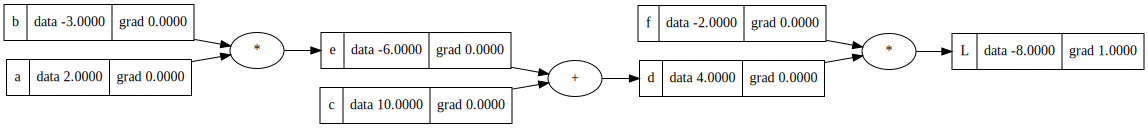

In [46]:
draw_dot(L)

In [47]:
f.grad  = 4.0
d.grad = -2.0
c.grad = -2.0 * 1.0
e.grad = -2.0 * 1.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [48]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)

In [49]:
lol()

3.9999999999995595


In [65]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



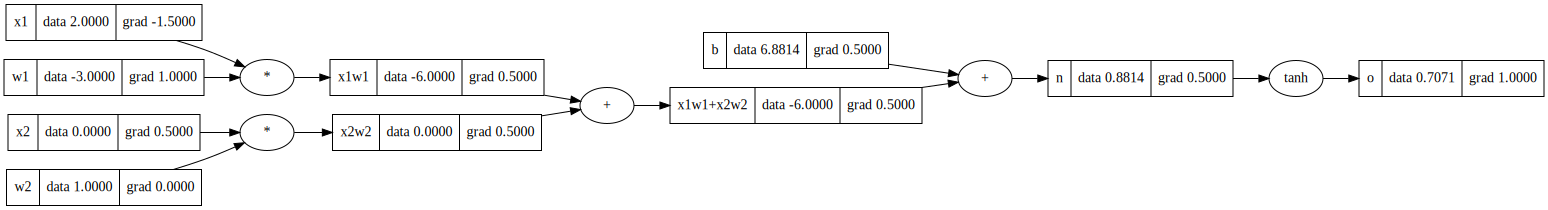

In [73]:
draw_dot(o)

In [71]:
topo = []
visited = set()
def build_topo(v):
	if v not in visited:
		visited.add(v)
		for child in v._prev:
			build_topo(child)
		topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [72]:
o.grad = 1.0
for node in reversed(topo):
	node._backward()